In [4]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

5084


# load csv

In [9]:
data_folder = r'V:\RNA_velocity'
import csv

In [10]:
# pseudotime
with open(os.path.join(data_folder, 'cell_pseudotime.csv'), 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get headers
    headers = next(reader)
    # data
    data = list(reader)
cell_names = [_d[0] for _d in data]
cell_pseudotimes = np.array([float(_d[1]) for _d in data])

In [13]:
# candidate gene list and selected_pvs
with open(os.path.join(data_folder, 'selected_pvs.csv'), 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get headers
    headers = next(reader)
    # data
    data = list(reader)
sel_genes = [_d[0] for _d in data]
sel_cc_pvals = np.array([float(_d[1]) for _d in data])


In [24]:
# load total rna counts
with open(os.path.join(data_folder, 'pnas.1912459116.sd12.csv'), 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get headers
    headers = next(reader)
    # data
    data = list(reader)
sel_total_counts = [[] for _gene in sel_genes]
for _line in data:
    if _line[0] in sel_genes:
        sel_total_counts[sel_genes.index(_line[0])] = [int(i) for i in _line[1:]]
sel_total_counts = np.array(sel_total_counts)

In [25]:
# load nuclear rna counts
with open(os.path.join(data_folder, 'pnas.1912459116.sd14.csv'), 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get headers
    headers = next(reader)
    # data
    data = list(reader)
sel_nuclear_counts = [[] for _gene in sel_genes]
for _line in data:
    if _line[0] in sel_genes:
        sel_nuclear_counts[sel_genes.index(_line[0])] = [int(i) for i in _line[1:]]
sel_nuclear_counts = np.array(sel_nuclear_counts)

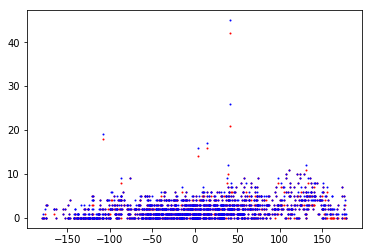

In [42]:
%matplotlib inline
gene_id = 6
plt.figure()
plt.plot(cell_pseudotimes, sel_nuclear_counts[gene_id], 'r.', markersize=2)
plt.plot(cell_pseudotimes, sel_total_counts[gene_id], 'b.', markersize=2)

plt.show()

In [23]:
np.array(sel_total_counts).shape

(521, 1368)

In [374]:
def winsorize(counts, cut_percentile=5):
    from scipy.stats import scoreatpercentile
    _counts = np.array(counts, dtype=np.float)
    _sel_inds = (_counts > scoreatpercentile(_counts, cut_percentile))\
                * (_counts <= scoreatpercentile(_counts, 100-cut_percentile))
    _counts[_sel_inds==False] = np.nan
    return _counts

In [58]:
winsorize(sel_total_counts[0])

array([0., 2., 1., ..., 1., 3., 2.])

2.04838068547023e-20


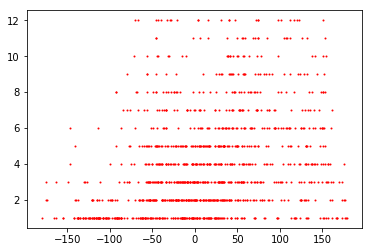

In [375]:
%matplotlib inline
gene_id = 9
print(sel_cc_pvals[gene_id])
_ind = np.isnan(winsorize(sel_total_counts[gene_id],5))==False
plt.figure()
plt.plot(cell_pseudotimes[_ind], sel_total_counts[gene_id][_ind], 'r.', markersize=2)

plt.show()

In [60]:
np.sum(_ind)

1332

In [61]:
len(cell_pseudotimes)

1368

In [76]:
(sel_genes).index('MCM6')

502

In [376]:
den_list = []

for gene_id,_gene in enumerate(sel_genes):
    _ind = np.isnan(winsorize(sel_total_counts[gene_id],2.5))==False
    dens, xbins, ybins = np.histogram2d(cell_pseudotimes[_ind], sel_total_counts[gene_id,_ind], bins=[15,10], density=False)
    den_list.append(dens/np.sum(dens, axis=1)[:,np.newaxis]/dens.shape[0])

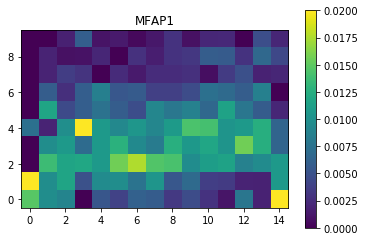

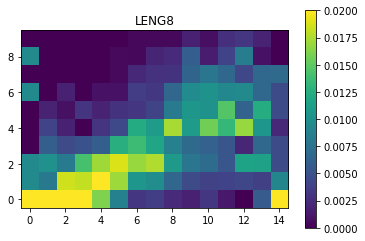

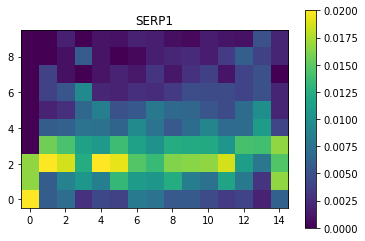

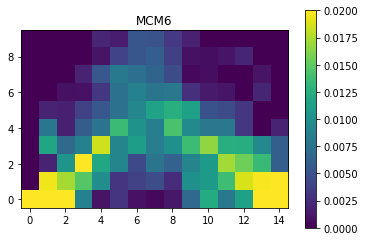

In [390]:
for i in [461,469,427,502]:
    plt.figure()
    plt.imshow(den_list[i].T, vmin=0, vmax=0.02)
    plt.colorbar()
    plt.title(sel_genes[i])
    plt.ylim([-0.5,9.5])
    plt.show()

In [356]:
np.sum(den_list[501])

1.0

In [357]:
def mutual_info(p, q, log_base=2):
    _kept_inds = (p>0) * (q>0)
    _p = p[_kept_inds]
    _q = q[_kept_inds]
    _MI = np.nansum(-np.log(_p)*_q/np.log(log_base) \
                    + -np.log(_q)*_p/np.log(log_base))
    return _MI

In [378]:
rv_den_list = [np.ravel(_d) for _d in den_list]


In [379]:
coefs = np.corrcoef(np.array(rv_den_list), rowvar=True)

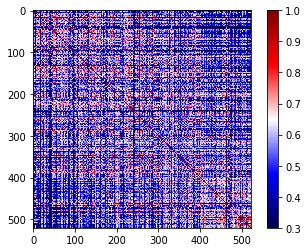

In [380]:
plt.figure()
plt.imshow(coefs, cmap='seismic', vmin=0.3, vmax=1)
plt.colorbar()
plt.show()

In [381]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage,dendrogram,to_tree


In [382]:
lk = linkage(coefs, method='ward')
rootnode, nodelist = to_tree(lk, rd=True)

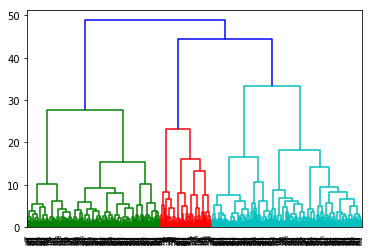

In [383]:
dn = dendrogram(lk)

In [384]:
_dist_th = 12
_kept_clusters= []
for _node in nodelist:
    _kept_leafs = []
    for _n in _kept_clusters:
        _kept_leafs += list(_n.pre_order(lambda x: x.id))
    _left_flag, _right_flag = True, True
    if not _node.is_leaf() and _node.dist > _dist_th:
        for _r in _node.left.pre_order(lambda x: x.id):
            if _r in _kept_leafs:
                _left_flag = False
                continue
        for _r in _node.right.pre_order(lambda x: x.id):
            if _r in _kept_leafs:
                _right_flag = False
                continue
        # otherwise, keep
        if _left_flag:
            _kept_clusters.append(_node.left)
        if _right_flag:
            _kept_clusters.append(_node.right)

In [385]:
ind_list = []
for _node in _kept_clusters:
    _gids = np.sort(list(_node.pre_order(lambda x: x.id))).astype(np.int)
    ind_list.append(_gids)

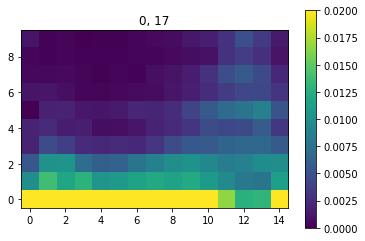

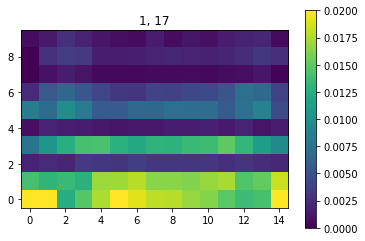

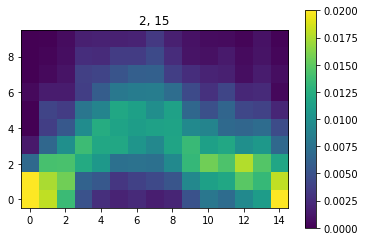

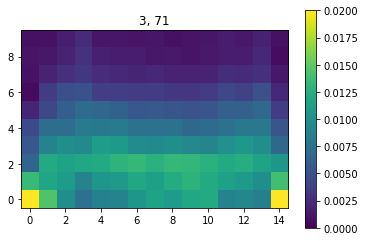

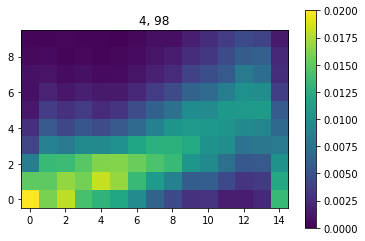

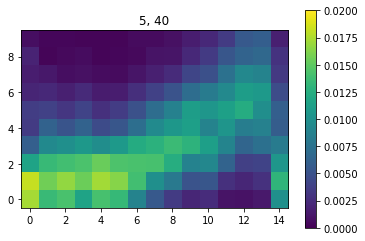

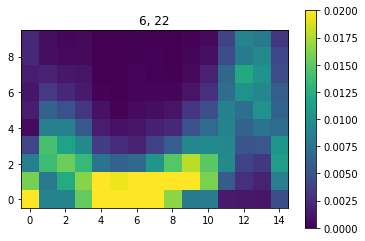

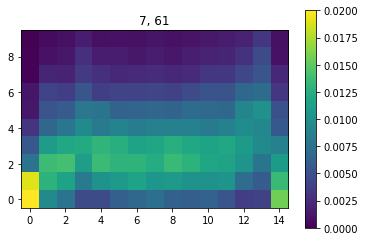

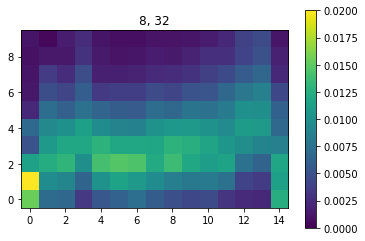

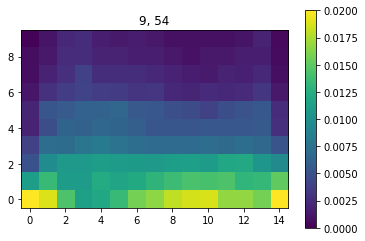

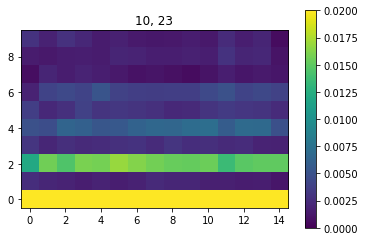

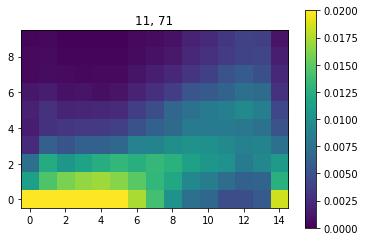

In [386]:
mean_den_list = []
for _i, _inds in enumerate(ind_list):
    mean_den = np.mean(np.array(den_list)[_inds], axis=0)
    plt.figure()
    plt.imshow(mean_den.T, vmin=0, vmax=0.02)
    plt.colorbar()
    plt.title(f"{_i}, {len(_inds)}")
    plt.ylim(-0.5,9.5)
    plt.show()

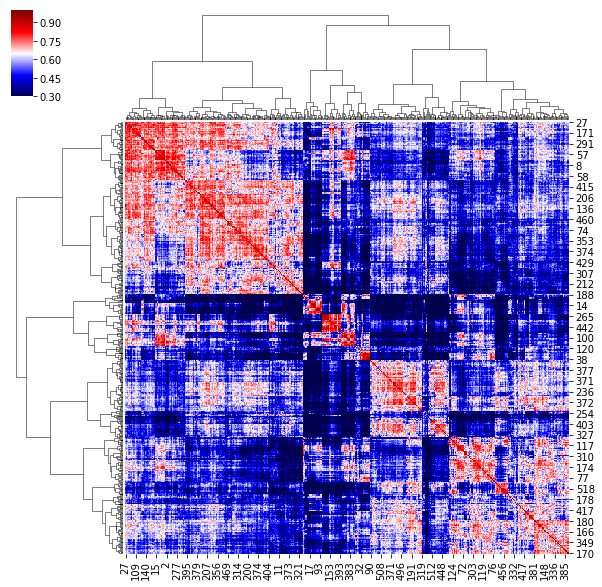

In [387]:
high_g = sns.clustermap(coefs, #col_linkage=lk, row_linkage=lk, 
                   method='ward', figsize=(10,10),
                   cmap='seismic', vmin=0.3, vmax=1)
                   #xticklabels=rna_ids, yticklabels=rna_region_ids, annot_kws={"size": 24})

In [391]:
mks = []
sel_ind_groups = []
for _inds in ind_list:
    _pvals = sel_cc_pvals[_inds]
    _mk = np.median(np.log(_pvals))
    mks.append(_mk)
    print(_mk)
    if _mk < -25:
        sel_ind_groups.append(_inds)
print(len(sel_ind_groups))

-39.18343085283318
-29.641627558270937
-54.697947311876106
-33.763571985745415
-32.51421648580125
-35.3687463762827
-70.07835124982816
-27.91265240398746
-34.3169079709221
-37.91505270617647
-27.437486079277
-33.51306321412374
12


In [393]:
subset_genes = []
subset_pvals = []
for _inds in sel_ind_groups:
    _pvals = sel_cc_pvals[_inds]
    #_n_sel = int(210/)
    _sel_i = np.argsort(_pvals)[:int(210/len(sel_ind_groups))]
    _sel_inds = _inds[_sel_i]
    subset_genes += list(np.array(sel_genes)[_sel_inds])
    subset_pvals += list(_pvals[_sel_i])

In [394]:
len(subset_genes), len(subset_pvals)

(202, 202)

In [395]:
# write selected gene subset
import csv

with open(os.path.join(data_folder, 'selected_subset_pvs.csv'), mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    employee_writer.writerow(['gene', 'pval'])
    for _gene, _pval in zip(subset_genes, subset_pvals):
        employee_writer.writerow([_gene, _pval])
    #employee_writer.writerow(['Erica Meyers', 'IT', 'March'])


In [353]:
lk

array([[1.94000000e+02, 2.79000000e+02, 4.71124594e-01, 2.00000000e+00],
       [1.00000000e+00, 3.50000000e+01, 5.25881891e-01, 2.00000000e+00],
       [3.10000000e+01, 1.00000000e+02, 5.70712271e-01, 2.00000000e+00],
       ...,
       [1.03300000e+03, 1.03500000e+03, 2.54787450e+01, 2.30000000e+02],
       [1.03200000e+03, 1.03700000e+03, 5.16147271e+01, 2.91000000e+02],
       [1.03800000e+03, 1.03900000e+03, 5.65750934e+01, 5.21000000e+02]])